# Saving buffers at predefined time points

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure, filters

import matplotlib.pyplot as plt, numpy as np, os
from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
width = 512
height = 512
channel_no = 3

#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *
#TODO: use cuda via numba
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# scratch from helper functions: 
TODO: make simple tests for them and other helper functions.  Put those tests in a nice .py function or using a nice pytest-like notebook

In [2]:
# #TODO: list the time points that I'd like to save at.  make a folder to put them in
# #TODO: copy the 'generating tips'.  slim it down.  make it's time consistent with the predefined origin
# #TODO: edit it to save at those time points (i) buffers and (ii) .png with contours and tips indicated
# def count_tips(x_list):
#     return str(x_list).count('.')

# def find_files(filename, search_path):
#     result = []
#     for root, dir, files in os.walk(search_path):
#         if filename in files:
#             result.append(os.path.join(root, filename))
#     return result
# # def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, dpi, figsize=(15,15)):
# def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, figsize=(15,15), max_marker_size=800, lw=2):
#     '''computes display data; returns fig.'''
#     #plot figure
#     fig, ax = plt.subplots(1,figsize=figsize)
#     ax.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
#     ax.axis('off')

#     #plot contours, if any.  type 1 = contours_raw (blue), type 2 = contours_inc (green)
#     for n, contour in enumerate(contours_inc):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='g', zorder=2)
#     for n, contour in enumerate(contours_raw):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='b', zorder=2)

#     #plot tips, if any
#     n_values, y_values, x_values = tips
#     #     if len(n_values)>0:
#     for j in range(len(x_values)): 
#         ax.scatter(x = x_values[j], y = y_values[j], c='yellow', s=int(max_marker_size/(j+1)), zorder=3, marker = '*')
#     return fig

# reinitialize with a desired buffer

In [18]:
# data_dir.replace('Data/tip_log_chaos_circle6_','')[:-4]
sigma       = 1.5#1
threshold   = 0.9#0.95
V_threshold = 0.5
buffer_fn   = f'buffer_time_origin_primed_with_circle6.npy'
# buffer_fn   = f'buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy'
save_folder = 'Data/buffers_with_odd_tips_detected_ds_5_param_set_8'
time_start  = 0.#eval(buffer_fn[buffer_fn.find('time_')+len('time_'):-4])
descrip     = f"chaos_circle6_from_{time_start:.1f}_sigma_{sigma}_threshold_{threshold}_"
# data_dir    = find_files(buffer_fn,nb_dir)
data_dir    = f'{nb_dir}/Data/ic_600x600.101.npz'
if len(data_dir)==0:
    print("buffer not found.")
data_dir = data_dir[0]
assert(float(time_start) is not None)

print(f'loading initial buffer from {data_dir}.')
os.chdir(nb_dir)
txt = np.load(data_dir)
# txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')

#reinitialize records
tip_state_lst = []
tme = time_start
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(nb_dir+'/'+save_folder)

loading initial buffer from /Users/timothytyree/Documents/GitHub/care/notebooks/Data/buffer_time_origin_primed_with_circle6.npy.


for channel 0,
	max value: 0.8214290890552275
	min value: -2.573322898385136e-09
	mean value: 0.09046410831508604
	
for channel 1,
	max value: 1.0
	min value: 4.2697602840858717e-07
	mean value: 0.8207435935007262
	
for channel 2,
	max value: 0.9999357476142035
	min value: 0.925573091916123
	mean value: 0.9930837205877209
	
max value of change for each channel is 0.8214 , 1.0000, 0.9999.
max rate of change for each channel is 5.5484 , 0.0434, 0.0019.

 number of type 1 contour = 3,	number of type 2 contour = 6,
the number of tips are 0.


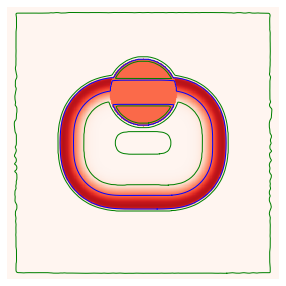

In [19]:
# check all the functions work/ compile the needed functions
zero_txt = txt.copy()*0.
time_step(txt, h=0.01, zero_txt=zero_txt)
# sigma       = 2
# threshold   = 0.95#0.95

describe(txt)
width, height, channel_no = txt.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#calculate contours and tips
img_nxt = txt[..., 0]
img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')
tips  = get_tips(contours_raw, contours_inc)
n_old = count_tips(tips[1])

#bluf
print('max value of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(txt,axis=(0,1)))))
print('max rate of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(dtexture_dt,axis=(0,1)))))

print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
print(f"the number of tips are {n_old}.")
# print(f"""the topological tip state:{tips[0]}""")
# print(f"""x position of tips: {tips[1]}""")
# print(f"""y position of tips: {tips[2]}""")
fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
plt.show()

In [5]:
# fig.savefig('origin_circle6.pdf', bbox_inches='tight',pad_inches=0)
plt.close()

## run the simulation

In [23]:
#integrate explicitely in time
timing = False
recording = True
recording_if_odd = True
h = 0.03
nsteps = 10**3#0#*10**4
start = time.time()
max_buffers_to_save = 5
buffers_saved = 0
start_saving_buffers_at_step = nsteps/2
tip_states = None
state = np.zeros((512,512,4),dtype=np.float64)
for step in range(nsteps):
    if not recording:
        #integrate explicitely in time
        time_step(txt, h=h, zero_txt=zero_txt) #up to twice as fast as for separated calls
        tme += h
    if recording:
        #calculate discrete flow map
        dtexture_dt = zero_txt.copy()
        get_time_step(txt, dtexture_dt)
        
        #integrate explicitely in time by the forward euler method
        txt += h*dtexture_dt
        tme += h
        
        #compute contours. type 1 = contours_raw, type 2 = contours_inc
        img_nxt = txt[..., 0].copy()
        img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
        img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
        contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
        contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')

        #compute spiral tips from the corssings 
        tips = get_tips(contours_raw, contours_inc)
        s_lst, x_lst, y_lst = tips
        tip_state_lst.append({
                    't': float(np.around(tme, 1)),
                    'x': tuple(x_lst),
                    'y': tuple(y_lst),
                    's': tuple(s_lst)})
        
        #determine if an odd number of tips were born        
        n = count_tips(x_lst) #counts the number of '.' in the nested list of x positions or just a normal list
        dn = n - n_old
        n_old = n
        
        #save the state if save_state == True as an .npy file
        #save_state = recording_if_odd & odd_event & odd_tip_number # ==> odd birth/death event has just occurred
        save_state = recording_if_odd & (dn%2!=0) & (n%2!=0)
        if save_state:
            fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
            fig.savefig(f'plot_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.pdf', bbox_inches='tight',pad_inches=0);
            plt.close();
            if step>start_saving_buffers_at_step:
                if buffers_saved<max_buffers_to_save:
                    buffers_saved += 1
                    np.save(f'buffer_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.npy', txt)
    printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)

#report the bottom line up front
print(f"time integration complete. time elapsed was {time.time()-start:.2f} seconds")
print(f"current time is {tme:.1f}.")
print(f"number of nan pixel voltages is {np.max(sum(np.isnan(txt[...,0])))}.")
print(f"current max voltage is {np.nanmax(txt[...,0]):.4f}.")
print(f"current max fast variable is {np.nanmax(txt[...,1]):.4f}.")
print(f"current max slow variable is {np.nanmax(txt[...,2]):.4f}.")
n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
# print(f"tip_states are {tip_states}.")
# print(f'current tip state is {tip_states}')
# if len(lst)~=0:
# print(f"number of tips is = {set([len(q) for q in lst_x[-1]])}.") #most recent number of tips

if recording:
    tips = get_tips(contours_raw, contours_inc);
    print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
    print(f"the number of tips are {count_tips(tips[1])}.")
    #     print(f"""the topological tip state is the following:{tips[0]}""")
beep(1)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
time integration complete. time elapsed was 412.00 seconds
current time is 33.0.
number of nan pixel voltages is 0.
current max voltage is 1.0083.
current max fast variable is 1.0000.
current max slow variable is 1.0000.

 number of type 1 contour = 6,	number of type 2 contour = 5,
the number of tips are 2.


0

sigma = 2 and threshold = 0.95.


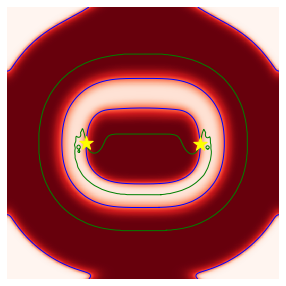

0

In [26]:
#DONE: verify h=0.01 is stable.  if I show that h=0.03 appears stable for ds = 5
#DONE: wiggle sigma & threshold until they are working for these parameter.   sigma = 2, threshold = 0.95 seems to work.
#DONE: njit it back up.
#TODO: start a simulation going past t=3000
#TODO: get intersection working with pbc
#TODO: restart ^that simulation 
n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
print(f"sigma = {sigma} and threshold = {threshold}.")
fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
plt.show()
beep(3)

## save tip log

In [ ]:
save = True
if save:
    df = pd.DataFrame(tip_state_lst)
    df.to_csv(f'{nb_dir}/Data/tip_log_{descrip}_at_time_{tme:.1f}.csv', index=False)
print('saved to:')
print(f'Data/tip_log__{descrip}_at_time_{tme:.1f}.csv')

## save plot of buffer/contours/tips

In [ ]:
#view/save the buffer with contours and tips plotted
save = False
save_file_name = f'buffer_{descrip}_at_time_{tme:.1f}'
save_dir = f"{nb_dir}/Figures/{save_file_name}.png"
image = txt.copy()

# experiment with different sigma and threshold
sigma       = 5/18*2#1
threshold   = 0.95


#compute display data
h = 0.1
# state = np.zeros((512,512,4),dtype=np.float64)
# get_tissue_state(texture=txt, out=state[...])
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)
img_nxt = txt[...,0].copy()
img_inc = txt[...,0].copy()
#plot figure
plt.figure(figsize=(15,15))
plt.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
# plt.title("voltage increases with red", fontsize=24)

#plot contours, if any.  type 1 = contours_raw, type 2 = contours_inc
img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold,fully_connected='low',positive_orientation='low')
for n, contour in enumerate(contours_inc):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='g', zorder=2)
for n, contour in enumerate(contours_raw):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='b', zorder=2)
plt.axis('off')

#plot tips, if any
tips = get_tips(contours_raw, contours_inc)
n_values, y_values, x_values = tips
for j in range(len(tips[2])): #nota bene, tips[2] is x_values
    plt.scatter(x = tips[2][j], y = tips[1][j], c='yellow', s=int(800/(j+1)), zorder=3, marker = '*')
print(f"current time is {tme:.1f}")
print(f"number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
print(f"""the topological tip state is the following: {n_values}""")
print(f"""x coords: {x_values}""")
print(f"""y coords: {y_values}""")
if save:
    plt.savefig(save_dir)
#     np.save(f'Data/{save_file_name}.npy', image)
    print('file saved at')
#     print(f'Data/{save_file_name}.npy')
#     np.savez_compressed(f'Data/{save_file_name}.npz', image)
else:
    plt.show()

In [ ]:


# n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
# tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}

# fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
#                   figsize=(5,5),max_marker_size=200, lw=1);
# fig.show()
beep(1)

In [ ]:
plt.close()

# Numerical stability requires small enough time step 
$$h\le0.01 ms \cdot\frac{\text{domain size}}{18 cm}$$

I noticed ^this after changing domain size from 18 cm to 5 cm.  I was using explicit forward euler integration through time.
- step 1, developed quick way to reproduce behavior
- step 2, saw if behavior persists for old parameter set/
    - $\rightarrow$ ^this tells me if the bug is in the code or in the parameters...
    


# Compressing WJ's example initial conditions to 28% of original file size 
- data type uneffected.  still float64
- ^his ic's didn't produce spiral defect chaos.

In [71]:
data_dir = f'{nb_dir}/Data/ic_600x600.101'
assert(os.path.exists(data_dir))
txt = np.loadtxt(data_dir)
txt = txt.reshape(600,600,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


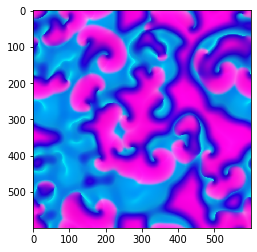

In [72]:
plt.imshow(txt)

In [73]:
print(txt.dtype)
describe(txt)

float64
for channel 0,
	max value: 1.0191668451289984
	min value: 0.0002091044690747812
	mean value: 0.4273355540736459
	
for channel 1,
	max value: 0.939233331559598
	min value: 2.524558960720931e-08
	mean value: 0.2652040224232269
	
for channel 2,
	max value: 0.9890739569674408
	min value: 0.6557470028121303
	mean value: 0.8796223397282353
	


In [74]:
np.savez_compressed(f'{nb_dir}/Data/ic_600x600.101.npz', txt)

In [63]:
f'{nb_dir}/Data/ic_600x600.101.npz'
txt = np.load(data_dir)['arr_0']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


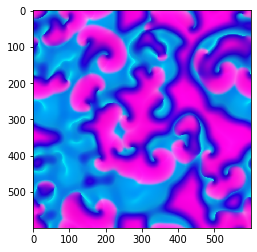

In [69]:
plt.imshow(A['arr_0'])

In [70]:
print(txt.dtype)
describe(txt)

float64
for channel 0,
	max value: 1.0191668451289984
	min value: 0.0002091044690747812
	mean value: 0.4273355540736459
	
for channel 1,
	max value: 0.939233331559598
	min value: 2.524558960720931e-08
	mean value: 0.2652040224232269
	
for channel 2,
	max value: 0.9890739569674408
	min value: 0.6557470028121303
	mean value: 0.8796223397282353
	


0.2852112676056338